1. Criar o Circuito Teletransporte
2. Gerar um estado quântico (psi) aleatório para ser teletransportado de Alice para Bob
3. Adicionar esse estado quântico no circuito teletransporte
4. Simular esse circuito no Simulador AER
5. Plotar os resultados na esfera de bloch e comparar com o estado inicial

In [1]:
# Do the necessary imports
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
from qiskit.ignis.verification import marginal_counts https://github.com/Qiskit/qiskit-ignis
from qiskit.quantum_info import random_statevector

In [2]:
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

In [3]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

In [4]:
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

In [5]:
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'

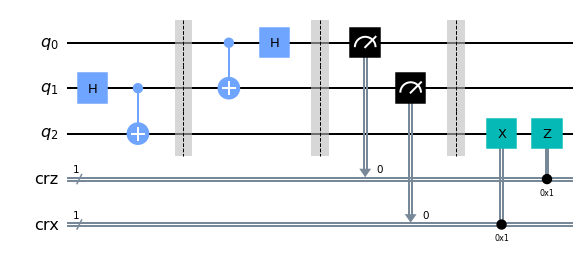

In [6]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0, 1)

## STEP 4
teleportation_circuit.barrier() # Use barrier to separate steps
bob_gates(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw(output='mpl')

    SIMULANDO O TELETRANSPORTE
    

In [7]:
from qiskit.quantum_info import random_statevector, Statevector
from qiskit import *
from qiskit.visualization import *

<IPython.core.display.Latex object>

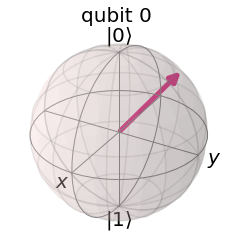

In [8]:
# Create random 1-qubit state
psi = random_statevector(2)

# Display it nicely
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))
# Show it on a Bloch sphere
plot_bloch_multivector(psi)

In [9]:
#from qiskit.extensions import Initialize
init_gate = Initialize(psi)
init_gate.label = "init"

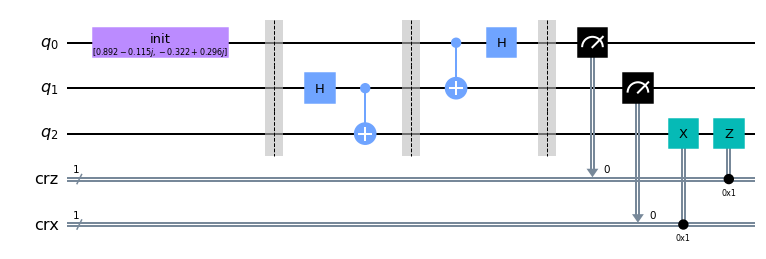

In [11]:
## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

# Display the circuit
qc.draw(output='mpl')

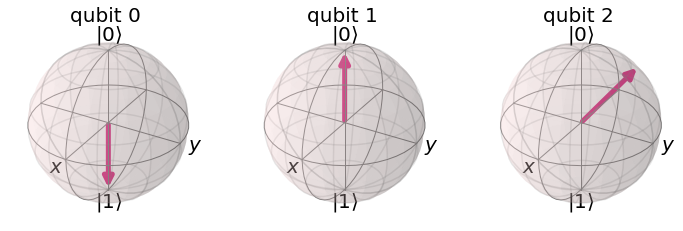

In [12]:
sim = Aer.get_backend('aer_simulator')
qc.save_statevector()
out_vector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(out_vector)

Lembrando o Estado inicial : Q1 (estado inicial em Alice)

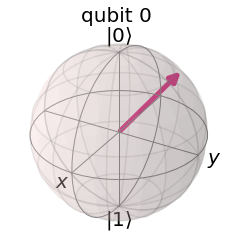

In [16]:
plot_bloch_multivector(psi)


In [26]:
inverse_init_gate = init_gate.gates_to_uncompute()

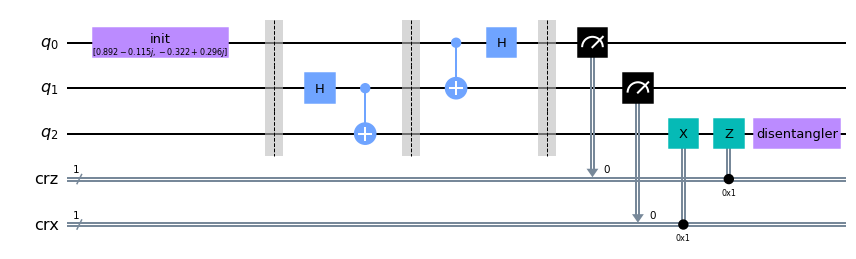

In [29]:
## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

## STEP 5
# reverse the initialization process
qc.append(inverse_init_gate, [2])

# Display the circuit
qc.draw(output='mpl')

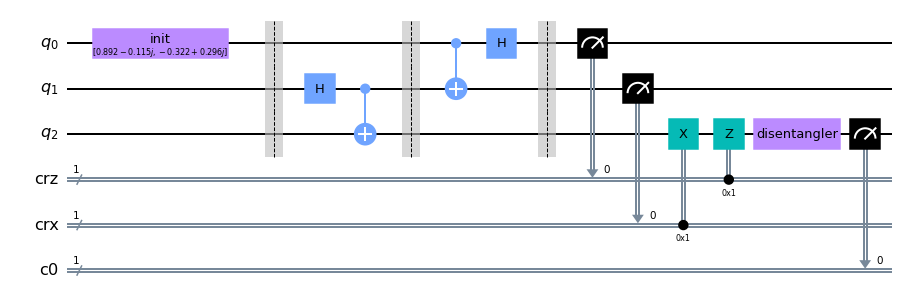

In [30]:
# Need to add a new ClassicalRegister
# to see the result
cr_result = ClassicalRegister(1)
qc.add_register(cr_result)
qc.measure(2,2)
qc.draw(output='mpl')

In [38]:
# This code is part of Qiskit.
#
# (C) Copyright IBM 2017, 2018.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

# pylint: disable=c-extension-no-member

"""Utility functions for working with Results."""

from typing import Sequence, Union, Optional, Dict, List
from collections import Counter
from copy import deepcopy

import numpy as np

from qiskit.exceptions import QiskitError
from qiskit.result.result import Result
from qiskit.result.counts import Counts
from qiskit.result.distributions.probability import ProbDistribution
from qiskit.result.distributions.quasi import QuasiDistribution

from qiskit.result.postprocess import _bin_to_hex

from qiskit._accelerate import results as results_rs  # pylint: disable=no-name-in-module


def marginal_counts(
    result: Union[dict, Result],
    indices: Optional[List[int]] = None,
    inplace: bool = False,
    format_marginal: bool = False,
    marginalize_memory: Optional[bool] = True,
) -> Union[Dict[str, int], Result]:
    """Marginalize counts from an experiment over some indices of interest.

    Args:
        result: result to be marginalized
            (a Result object or a dict(str, int) of counts).
        indices: The bit positions of interest
            to marginalize over. If ``None`` (default), do not marginalize at all.
        inplace: Default: False. Operates on the original Result
            argument if True, leading to loss of original Job Result.
            It has no effect if ``result`` is a dict.
        format_marginal: Default: False. If True, takes the output of
            marginalize and formats it with placeholders between cregs and
            for non-indices.
        marginalize_memory: If True, then also marginalize the memory field (if present).
            If False, remove the memory field from the result.
            If None, leave the memory field as is.

    Returns:
        Result or dict(str, int): A Result object or a dictionary with
            the observed counts, marginalized to only account for frequency
            of observations of bits of interest.

    Raises:
        QiskitError: in case of invalid indices to marginalize over.
    """
    if isinstance(result, Result):
        if not inplace:
            result = deepcopy(result)
        for i, experiment_result in enumerate(result.results):
            counts = result.get_counts(i)
            new_counts = _marginalize(counts, indices)
            new_counts_hex = {}
            for k, v in new_counts.items():
                new_counts_hex[_bin_to_hex(k)] = v
            experiment_result.data.counts = new_counts_hex

            if indices is not None:
                experiment_result.header.memory_slots = len(indices)
                csize = getattr(experiment_result.header, "creg_sizes", None)
                if csize is not None:
                    experiment_result.header.creg_sizes = _adjust_creg_sizes(csize, indices)

            if getattr(experiment_result.data, "memory", None) is not None and indices is not None:
                if marginalize_memory is False:
                    delattr(experiment_result.data, "memory")
                elif marginalize_memory is None:
                    pass  # leave as is
                else:
                    sorted_indices = sorted(
                        indices, reverse=True
                    )  # same convention as for the counts
                    experiment_result.data.memory = results_rs.marginal_memory(
                        experiment_result.data.memory, sorted_indices, return_hex=True
                    )
        return result
    else:
        marg_counts = _marginalize(result, indices)
        if format_marginal and indices is not None:
            marg_counts = _format_marginal(result, marg_counts, indices)
        return marg_counts



def _adjust_creg_sizes(creg_sizes, indices):
    """Helper to reduce creg_sizes to match indices"""

    # Zero out creg_sizes list
    new_creg_sizes = [[creg[0], 0] for creg in creg_sizes]
    indices_sort = sorted(indices)

    # Get creg num values and then convert to the cumulative last index per creg.
    # e.g. [2, 1, 3] => [1, 2, 5]
    creg_nums = [x for _, x in creg_sizes]
    creg_limits = [sum(creg_nums[0:x:1]) - 1 for x in range(0, len(creg_nums) + 1)][1:]

    # Now iterate over indices and find which creg that index is in.
    # When found increment the creg size
    creg_idx = 0
    for ind in indices_sort:
        for idx in range(creg_idx, len(creg_limits)):
            if ind <= creg_limits[idx]:
                creg_idx = idx
                new_creg_sizes[idx][1] += 1
                break
    # Throw away any cregs with 0 size
    new_creg_sizes = [creg for creg in new_creg_sizes if creg[1] != 0]
    return new_creg_sizes


def marginal_memory(
    memory: Union[List[str], np.ndarray],
    indices: Optional[List[int]] = None,
    int_return: bool = False,
    hex_return: bool = False,
    avg_data: bool = False,
    parallel_threshold: int = 1000,
) -> Union[List[str], np.ndarray]:
    """Marginalize shot memory

    This function is multithreaded and will launch a thread pool with threads equal to the number
    of CPUs by default. You can tune the number of threads with the ``RAYON_NUM_THREADS``
    environment variable. For example, setting ``RAYON_NUM_THREADS=4`` would limit the thread pool
    to 4 threads.

    Args:
        memory: The input memory list, this is either a list of hexadecimal strings to be marginalized
            representing measure level 2 memory or a numpy array representing level 0 measurement
            memory (single or avg) or level 1 measurement memory (single or avg).
        indices: The bit positions of interest to marginalize over. If
            ``None`` (default), do not marginalize at all.
        int_return: If set to ``True`` the output will be a list of integers.
            By default the return type is a bit string. This and ``hex_return``
            are mutually exclusive and can not be specified at the same time. This option only has an
            effect with memory level 2.
        hex_return: If set to ``True`` the output will be a list of hexadecimal
            strings. By default the return type is a bit string. This and
            ``int_return`` are mutually exclusive and can not be specified
            at the same time. This option only has an effect with memory level 2.
        avg_data: If a 2 dimensional numpy array is passed in for ``memory`` this can be set to
            ``True`` to indicate it's a avg level 0 data instead of level 1
            single data.
        parallel_threshold: The number of elements in ``memory`` to start running in multiple
            threads. If ``len(memory)`` is >= this value, the function will run in multiple
            threads. By default this is set to 1000.

    Returns:
        marginal_memory: The list of marginalized memory

    Raises:
        ValueError: if both ``int_return`` and ``hex_return`` are set to ``True``
    """
    if int_return and hex_return:
        raise ValueError("Either int_return or hex_return can be specified but not both")

    if isinstance(memory, np.ndarray):
        if int_return:
            raise ValueError("int_return option only works with memory list input")
        if hex_return:
            raise ValueError("hex_return option only works with memory list input")
        if indices is None:
            return memory.copy()
        if memory.ndim == 1:
            return results_rs.marginal_measure_level_1_avg(memory, indices)
        if memory.ndim == 2:
            if avg_data:
                return results_rs.marginal_measure_level_0_avg(memory, indices)
            else:
                return results_rs.marginal_measure_level_1(memory, indices)
        if memory.ndim == 3:
            return results_rs.marginal_measure_level_0(memory, indices)
        raise ValueError("Invalid input memory array")
    return results_rs.marginal_memory(
        memory,
        indices,
        return_int=int_return,
        return_hex=hex_return,
        parallel_threshold=parallel_threshold,
    )



def marginal_distribution(
    counts: dict,
    indices: Optional[Sequence[int]] = None,
    format_marginal: bool = False,
) -> Dict[str, int]:
    """Marginalize counts from an experiment over some indices of interest.

    Unlike :func:`~.marginal_counts` this function respects the order of
    the input ``indices``. If the input ``indices`` list is specified then the order
    the bit indices are specified will be the output order of the bitstrings
    in the marginalized output.

    Args:
        counts: result to be marginalized
        indices: The bit positions of interest
            to marginalize over. If ``None`` (default), do not marginalize at all.
        format_marginal: Default: False. If True, takes the output of
            marginalize and formats it with placeholders between cregs and
            for non-indices.
    Returns:
        dict(str, int): A marginalized dictionary
    Raises:
        QiskitError: If any value in ``indices`` is invalid or the ``counts`` dict
        is invalid.
    """
    num_clbits = len(max(counts.keys()).replace(" ", ""))
    if indices is not None and (len(indices) == 0 or not set(indices).issubset(range(num_clbits))):
        raise QiskitError(f"indices must be in range [0, {num_clbits - 1}].")

    if isinstance(counts, Counts):
        res = results_rs.marginal_counts(counts, indices)
    elif isinstance(counts, (ProbDistribution, QuasiDistribution)):
        res = results_rs.marginal_distribution(counts, indices)
    else:
        first_value = next(iter(counts.values()))
        if isinstance(first_value, int):
            res = results_rs.marginal_counts(counts, indices)
        elif isinstance(first_value, float):
            res = results_rs.marginal_distribution(counts, indices)
        else:
            raise QiskitError("Values of counts must be an int or float")

    if format_marginal and indices is not None:
        return _format_marginal(counts, res, indices)
    return res



def _marginalize(counts, indices=None):
    """Get the marginal counts for the given set of indices"""
    num_clbits = len(next(iter(counts)).replace(" ", ""))
    # Check if we do not need to marginalize and if so, trim
    # whitespace and '_' and return
    if (indices is None) or set(range(num_clbits)) == set(indices):
        ret = {}
        for key, val in counts.items():
            key = _remove_space_underscore(key)
            ret[key] = val
        return ret

    if not indices or not set(indices).issubset(set(range(num_clbits))):
        raise QiskitError(f"indices must be in range [0, {num_clbits - 1}].")

    # Sort the indices to keep in descending order
    # Since bitstrings have qubit-0 as least significant bit
    indices = sorted(indices, reverse=True)

    # Build the return list
    new_counts = Counter()
    for key, val in counts.items():
        new_key = "".join([_remove_space_underscore(key)[-idx - 1] for idx in indices])
        new_counts[new_key] += val
    return dict(new_counts)


def _format_marginal(counts, marg_counts, indices):
    """Take the output of marginalize and add placeholders for
    multiple cregs and non-indices."""
    format_counts = {}
    counts_template = next(iter(counts))
    counts_len = len(counts_template.replace(" ", ""))
    indices_rev = sorted(indices, reverse=True)

    for count in marg_counts:
        index_dict = dict(zip(indices_rev, count))
        count_bits = "".join(
            [index_dict[index] if index in index_dict else "_" for index in range(counts_len)]
        )[::-1]
        for index, bit in enumerate(counts_template):
            if bit == " ":
                count_bits = count_bits[:index] + " " + count_bits[index:]
        format_counts[count_bits] = marg_counts[count]
    return format_counts


def _remove_space_underscore(bitstring):
    """Removes all spaces and underscores from bitstring"""
    return bitstring.replace(" ", "").replace("_", "")

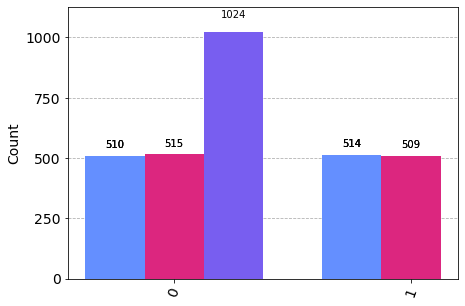

In [40]:
t_qc = transpile(qc, sim)
t_qc.save_statevector()
counts = sim.run(t_qc).result().get_counts()
qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(3)]
plot_histogram(qubit_counts)